In [1]:
from PIL import Image
import torch
import cv2
import os
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import numpy as np
import pandas as pd
import random
import io


In [2]:

# Load models for part and damage detection
def load_model(model_path, threshold, num_classes):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.MODEL.WEIGHTS = model_path
    cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    return DefaultPredictor(cfg)


In [3]:

predictor_part = load_model("https://huggingface.co/rarayayan/Detectron2-Zoo-Car-Parts-Detection/resolve/main/model_final.pth", 0.5, 21)
predictor_damage = load_model("https://huggingface.co/rarayayan/Detectron2-Zoo-Car-Damage-Detection/resolve/main/model_final.pth", 0.2, 8)

In [4]:

# Part category mapping
category_mapping_parts = {
    "Windshield": 0,
    "Back-windshield": 1,
    "Front-window": 2,
    "Back-window": 3,
    "Front-door": 4,
    "Back-door": 5,
    "Front-wheel": 6,
    "Cracked": 7,
    "Front-bumper": 8,
    "Back-bumper": 9,
    "Headlight": 10,
    "Tail-light": 11,
    "Hood": 12,
    "Trunk": 13,
    "License-plate": 14,
    "Mirror": 15,
    "Roof": 16,
    "Grille": 17,
    "Rocker-panel": 18,
    "Quarter-panel": 19,
    "Fender": 20
}

# Reverse mapping for part categories
id_to_part_name = {v: k for k, v in category_mapping_parts.items()}

# Damage category mapping
damage_mapping = {
    0: 'Dent',
    1: 'Cracked',
    2: 'Scratch',
    3: 'Flaking',
    4: 'Broken part',
    5: 'Paint chip',
    6: 'Missing part',
    7: 'Corrosion'
}


In [68]:
image = Image.open("C:\\Users\\setday\\Desktop\\photo_2025-06-07_13-21-44.jpg")
image = np.array(image)

In [69]:

# Step 3: Run part detection
output_part = predictor_part(image)
instances_part = output_part["instances"].to("cpu")
boxes_part = instances_part.pred_boxes
labels_part = instances_part.pred_classes
masks_part = instances_part.pred_masks

# Step 4: Run damage detection
output_damage = predictor_damage(image)
instances_damage = output_damage["instances"].to("cpu")
boxes_damage = instances_damage.pred_boxes
labels_damage = instances_damage.pred_classes

In [70]:
from torchvision.utils import draw_segmentation_masks

In [71]:
from matplotlib import pyplot as plt

def visualise(image, preds, threshold=0.5):

    color_map = {
        "Windshield": "#FF0000",  # red
        "Back-windshield": "#00FF00",  # green
        "Front-window": "#0000FF",  # blue
        "Back-window": "#FFFF00",  # yellow
        "Front-door": "#FFA500",  # orange
        "Back-door": "#800080",  # purple
        "Front-wheel": "#00FFFF",  # cyan
        "Cracked": "#FF00FF",  # magenta
        "Front-bumper": "#808080",  # gray
        "Back-bumper": "#FFC0CB",  # pink
        "Headlight": "#FFD700",  # gold
        "Tail-light": "#A52A2A",  # brown
        "Hood": "#FF4500",  # orange-red
        "Trunk": "#8B4513",  # saddle brown
        "License-plate": "#D3D3D3",  # light gray
        "Mirror": "#ADD8E6",  # light blue
        "Roof": "#90EE90",  # light green
        "Grille": "#DDA0DD",  # plum
        "Rocker-panel": "#FF69B4",  # hot pink
        "Quarter-panel": "#B0C4DE",  # light steel blue
        "Fender": "#FFB6C1",  # light pink

        "Dent": "#008b00",
        "Cracked": "#8b0000",
        "Scratch": "#00008b",
        "Flaking": "#8b008b",
        "Broken part": "#ff8c00",
        "Paint chip": "#ffa500",
        "Missing part": "#b22222",
        "Corrosion": "#a9a9a9"
    }

    image = torch.tensor(image).permute(2, 0, 1) 

    for mask, score, label in zip(preds['masks'], preds['scores'], preds['labels']):
        if score < threshold:
            continue

        mask = mask.numpy()
        color = color_map[label]
        image = draw_segmentation_masks(
            image=image,
            masks=torch.tensor(mask, dtype=torch.bool),
            colors=color,
            alpha=0.3
        )

    image = image.permute(1, 2, 0).numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    plt.axis('off')
    plt.show()

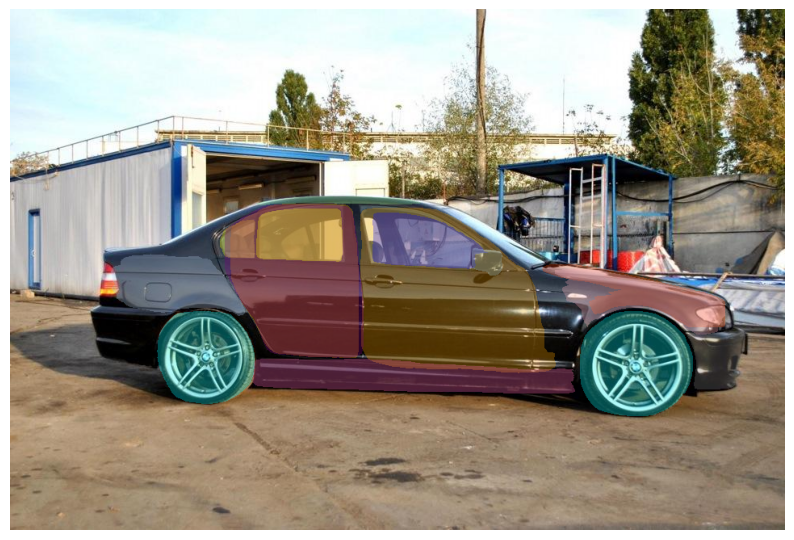

In [72]:
output_part = predictor_part(image)
instances_part = output_part["instances"].to("cpu")
boxes_part = instances_part.pred_boxes
labels_part = instances_part.pred_classes
masks_part = instances_part.pred_masks

pred = {
    "masks": instances_part.pred_masks,
    "labels": [id_to_part_name[label.item()] for label in instances_part.pred_classes],
    "scores": instances_part.scores
}

visualise(image, pred, threshold=0.25)

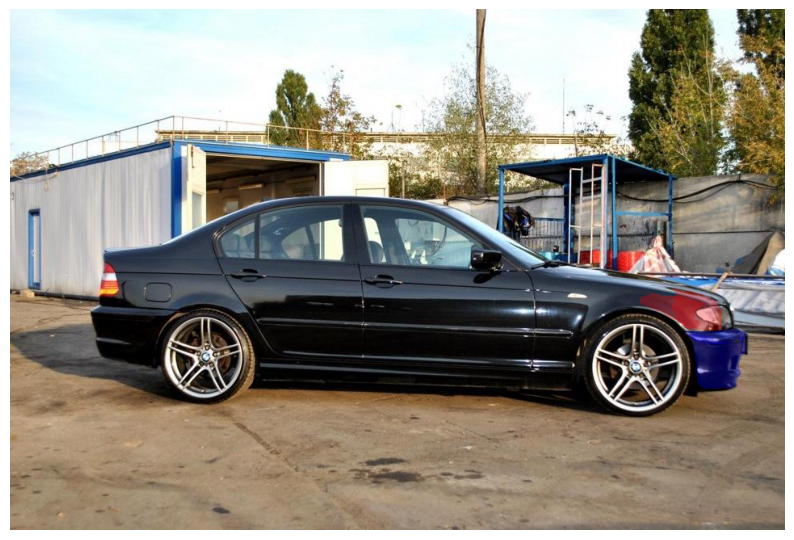

In [73]:
output_part = predictor_damage(image)
instances_part = output_part["instances"].to("cpu")
boxes_part = instances_part.pred_boxes
labels_part = instances_part.pred_classes
masks_part = instances_part.pred_masks

pred = {
    "masks": instances_part.pred_masks,
    "labels": [id_to_part_name[label.item()] for label in instances_part.pred_classes],
    "scores": instances_part.scores
}

visualise(image, pred, threshold=0.45)